In [2]:

import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import pydicom
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
from IPython.display import update_display
from subprocess import Popen
PATH = "/mnt/d/CBIS-DDSM/"
roipath = PATH + "new_ROI/"
save = roipath + 'resize_with_padding/'
# malignant_roi_path = PATH + "ROI/malignant/"
# fullimg_benign_path = PATH + "fullimg/benign/"
# fullimg_malignant_path = PATH + "fullimg/malignant/"
img_height=300
img_width=300




2023-03-30 02:24:20.011538: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-30 02:24:21.056898: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jj/miniconda3/envs/tf/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/cuda/include:/usr/local/cuda/lib64:/usr/local/cuda-11.2/lib64::/usr/local/cuda/extras/CUPTI/lib64:/home/jj/miniconda3/envs/tf/lib/
2023-03-30 02:24:21.056997: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugi

In [3]:
# for dirName, subdirList, fileList in os.walk(imgPATH):
    # for fname in fileList:
        # if fname.endswith('.dcm'):
            # dcm_path = dirName+'/'+fname
            # img_path = dirName+'/'+fname.replace('.dcm','.png')
            # Popen(['convert',dcm_path,img_path]).wait()

In [4]:
calc_train = pd.read_csv(PATH + "csv/calc_case_description_train_set.csv")
mass_train = pd.read_csv(PATH + "csv/mass_case_description_train_set.csv")
calc_train = calc_train[['patient_id','left or right breast','image view','pathology','calc type','ROI mask file path','breast density','assessment']]
mass_train = mass_train[['patient_id','left or right breast','image view','pathology','mass shape','cropped image file path','breast_density','assessment']]
information = pd.read_csv(PATH + "csv/dicom_info.csv")
information = information[['image_path','PatientID','SeriesDescription','SeriesInstanceUID']]
cropped_information = information.loc[information['SeriesDescription']=='cropped images']
ROI_mask_information = information.loc[information['SeriesDescription']=='ROI mask images']


In [5]:
train_benign = np.empty((1,8), dtype=object)
val_benign = np.empty((1,8), dtype=object)
train_malignant = np.empty((1,8), dtype=object)
val_malignant = np.empty((1,8), dtype=object)
# rng = np.random.default_rng(seed=124)
benign_calc = calc_train.loc[calc_train['pathology']=='BENIGN']
benign_calc =  benign_calc.groupby(['calc type','breast density','assessment'])
rng = np.random.default_rng(seed=48)
arrays = {}
for name, group in benign_calc:
    arrays[name] = np.array(group)
for name, array in arrays.items():
    for dat in array[:]:
        dat[5] = dat[5].split('/')[-2]
    if len(array) >3:
        array = rng.permutation(array)
        train_benign = np.concatenate((train_benign,array[:int(0.8*len(array))]))
        val_benign = np.concatenate((val_benign,array[int(0.8*len(array)):]))
    else:
        train_benign = np.concatenate((train_benign,array))
malignant_calc = calc_train.loc[calc_train['pathology']=='MALIGNANT']
malignant_calc =  malignant_calc.groupby(['calc type','breast density','assessment'])
rng = np.random.default_rng(seed=42)
arrays = {}
for name, group in malignant_calc:
    arrays[name] = np.array(group)
for name, array in arrays.items():
    for dat in array[:]:
        dat[5] = dat[5].split('/')[-2]
    if len(array) >3:
        array = rng.permutation(array)
        train_malignant = np.concatenate((train_malignant,array[:int(0.8*len(array))]))
        val_malignant = np.concatenate((val_malignant,array[int(0.8*len(array)):]))
    else:
        train_malignant = np.concatenate((train_malignant,array))
benign_mass = mass_train.loc[mass_train['pathology']=='BENIGN']
benign_mass =  benign_mass.groupby(['mass shape','breast_density','assessment'])
arrays = {}
for name, group in benign_mass:
    arrays[name] = np.array(group)

for name, array in arrays.items():
    # print(name)
    for dat in array[:]:
        dat[5] = dat[5].split('/')[-2]
    if len(array) >3:
        array = rng.permutation(array)
        train_benign = np.concatenate((train_benign,array[int(0.2*len(array)):]))
        val_benign = np.concatenate((val_benign,array[:int(0.2*len(array))]))
    else:
        train_benign = np.concatenate((train_benign,array))
malignant_mass = mass_train.loc[mass_train['pathology']=='MALIGNANT']
malignant_mass =  malignant_mass.groupby(['mass shape','breast_density','assessment'])
arrays = {}
for name, group in malignant_mass:
    arrays[name] = np.array(group)
for name, array in arrays.items():
    for dat in array[:]:
        dat[5] = dat[5].split('/')[-2]
    if len(array) >3:
        array = rng.permutation(array)
        train_malignant = np.concatenate((train_malignant,array[int(0.2*len(array)):]))
        val_malignant = np.concatenate((val_malignant,array[:int(0.2*len(array))]))
    else:
        train_malignant = np.concatenate((train_malignant,array))
train_benign = train_benign[1:]
val_benign = val_benign[1:]
train_malignant = train_malignant[1:]
val_malignant = val_malignant[1:]

In [6]:
ignore_id = []
for dirName, subdirList, fileList in os.walk(roipath+'Need_Revise/'):
    for fname in fileList:
        if fname.endswith('.png'):
            ignore_id.append('_'.join(fname.split('.')[0].split('_')[:-1]))
# print(ignore_id)

In [7]:
calc_test = pd.read_csv(PATH + "csv/calc_case_description_test_set.csv")
mass_test = pd.read_csv(PATH + "csv/mass_case_description_test_set.csv")
calc_test = calc_test[['patient_id','left or right breast','image view','pathology','calc type','ROI mask file path','breast density','assessment']]
mass_test = mass_test[['patient_id','left or right breast','image view','pathology','mass shape','cropped image file path','breast_density','assessment']]
# test_benign = np.empty((1,8), dtype=object)
# test_malignant = np.empty((1,8), dtype=object)
# for i in range(len(mass_test)):
    # test = mass_test.iloc[i].to_numpy()
    # test[5] = test[5].split('/')[-2]
    # if test[3] == 'BENIGN':
        # test_benign = np.concatenate((test_benign,[test]))
    # elif test[3] == 'MALIGNANT':
        #  test_malignant = np.concatenate((test_malignant,[test]))
# for i in range(len(calc_test)):
    # test = calc_test.iloc[i].to_numpy()
    # test[5] = test[5].split('/')[-2]
    # if test[3] == 'BENIGN':
        # test_benign = np.concatenate((test_benign,[test]))
    # elif test[3] == 'MALIGNANT':
        # test_malignant = np.concatenate((test_malignant,[test]))
# test_benign = test_benign[1:]
# test_malignant = test_malignant[1:]
test_benign = np.empty((1,8), dtype=object)
test_val_benign = np.empty((1,8), dtype=object)
test_malignant = np.empty((1,8), dtype=object)
test_val_malignant = np.empty((1,8), dtype=object)
# rng = np.random.default_rng(seed=124)
benign_calc = calc_test.loc[calc_test['pathology']=='BENIGN']
benign_calc =  benign_calc.groupby(['calc type','breast density','assessment'])
rng = np.random.default_rng(seed=48)
arrays = {}
for name, group in benign_calc:
    arrays[name] = np.array(group)
for name, array in arrays.items():
    for dat in array[:]:
        dat[5] = dat[5].split('/')[-2]
    if len(array) >=2:
        array = rng.permutation(array)
        test_benign = np.concatenate((test_benign,array[:int(0.5*len(array))]))
        test_val_benign = np.concatenate((test_val_benign,array[int(0.5*len(array)):]))
    else:
        test_benign = np.concatenate((test_benign,array))
malignant_calc = calc_test.loc[calc_test['pathology']=='MALIGNANT']
malignant_calc =  malignant_calc.groupby(['calc type','breast density','assessment'])
# rng = np.random.default_rng(seed=42)
arrays = {}
for name, group in malignant_calc:
    arrays[name] = np.array(group)
for name, array in arrays.items():
    for dat in array[:]:
        dat[5] = dat[5].split('/')[-2]
    if len(array) >=2:
        array = rng.permutation(array)
        test_malignant = np.concatenate((test_malignant,array[:int(0.5*len(array))]))
        test_val_malignant = np.concatenate((test_val_malignant,array[int(0.5*len(array)):]))
    else:
        test_malignant = np.concatenate((test_malignant,array))
benign_mass = mass_test.loc[mass_test['pathology']=='BENIGN']
benign_mass =  benign_mass.groupby(['mass shape','breast_density','assessment'])
arrays = {}
for name, group in benign_mass:
    arrays[name] = np.array(group)

for name, array in arrays.items():
    # print(name)
    for dat in array[:]:
        dat[5] = dat[5].split('/')[-2]
    if len(array) >=2:
        array = rng.permutation(array)
        test_benign = np.concatenate((test_benign,array[int(0.5*len(array)):]))
        test_val_benign = np.concatenate((test_val_benign,array[:int(0.5*len(array))]))
    else:
        test_benign = np.concatenate((test_benign,array))
malignant_mass = mass_test.loc[mass_test['pathology']=='MALIGNANT']
malignant_mass =  malignant_mass.groupby(['mass shape','breast_density','assessment'])
arrays = {}
for name, group in malignant_mass:
    arrays[name] = np.array(group)
for name, array in arrays.items():
    for dat in array[:]:
        dat[5] = dat[5].split('/')[-2]
    if len(array) >=2:
        array = rng.permutation(array)
        test_malignant = np.concatenate((test_malignant,array[int(0.5*len(array)):]))
        test_val_malignant = np.concatenate((test_val_malignant,array[:int(0.5*len(array))]))
    else:
        test_malignant = np.concatenate((test_malignant,array))
test_benign = test_benign[1:]
test_val_benign = test_val_benign[1:]
test_malignant = test_malignant[1:]
test_val_malignant = test_val_malignant[1:]

# Functions

In [7]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
clahe2 = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

In [8]:
j = np.array(([-1,2,3],[0,-2,4]))
# x = np.where(j<0)
j = np.clip(j,0,255)


print(j)

[[0 2 3]
 [0 0 4]]


# Preprocessing

In [10]:
def remove_artefact(data):
    border_y = 2
    border_x = 2
    # Crop out some of the borders
    rect = cv2.rectangle(img=np.zeros((data.shape),dtype='uint8'),pt1=(border_x,border_y),pt2=(data.shape[1]-border_x, data.shape[0]-border_y),color=(255,255,255),thickness=-1)
    data = cv2.bitwise_and(data,data,mask=rect)
    # Mask the breast area and crop out the artifacts
    # _,thresh = cv2.threshold(data,127,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)
    # contours,_= cv2.findContours(data,mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
    # contour_placeholder = np.zeros((data.shape),np.uint8())
    # largest_contour = max(contours,key=cv2.contourArea)
    # contour_mask = cv2.drawContours(contour_placeholder,[largest_contour],contourIdx=0,color=(255,255,255),thickness=-1)
    # kernel = np.ones((10,10),np.uint8)
    # contour_mask = cv2.erode(cv2.dilate(contour_mask, kernel, iterations=5),kernel,iterations=1)
    # data = cv2.bitwise_and(data,data,mask=contour_mask)
    # mask sharp edges such as white image borders and remove the masked areas
    canny = cv2.Canny(data,50,255,apertureSize=3)
    canny = cv2.dilate(canny, np.ones((5,5),np.uint8), iterations=1)
    # _,thresh = cv2.threshold(canny,0,255,cv2.THRESH_BINARY)
    contour, _ = cv2.findContours(canny,mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
    contours = []
    for cont in contour:
        if cv2.contourArea(cont) > 7000 and cv2.contourArea(cont)<int(0.15*data.shape[0]*data.shape[1]) :
            contours.append(cont)
    if contours:
        canny_mask = cv2.drawContours(np.ones((data.shape),np.uint8()),contours,contourIdx=-1,color=(0,0,0),thickness=-1)
        canny_mask = np.invert(canny_mask)
        kernel = np.ones((5,5),np.uint8)
        canny_mask = cv2.dilate(canny_mask, kernel, iterations=1)
        canny_mask = cv2.erode(canny_mask,np.ones((7,7)),iterations=1)
        canny_mask = np.invert(canny_mask)
        data = cv2.bitwise_and(data,data,mask=canny_mask)
    # data = (np.power(data.astype('float')/255.0,2)*255).astype('uint8')
    # clahe = cv2.createCLAHE(1.0,(8,8))
    # data = clahe.apply(data)
    # Mask the breast area and crop out the artifacts
    _,thresh = cv2.threshold(data,127,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)
    contours,_= cv2.findContours(data,mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
    contour_placeholder = np.zeros((data.shape),np.uint8())
    largest_contour = max(contours,key=cv2.contourArea)
    contour_mask = cv2.drawContours(contour_placeholder,[largest_contour],contourIdx=0,color=(255,255,255),thickness=-1)
    kernel = np.ones((10,10),np.uint8)
    contour_mask = cv2.erode(cv2.dilate(contour_mask, kernel, iterations=1),kernel,iterations=3)
    data = cv2.bitwise_and(data,data,mask=contour_mask)


    return data

def resize_roi(x,y,w,h,data_shape):
    if int(1.2*w) < data_shape[1] and int(1.2*h) < data_shape[1]:
        x-=int(0.2*w/2)
        y-=int(0.2*h/2)
        w += int(0.2*w)
        h += int(0.2*h)
        if x+w > data_shape[1]: x = data_shape[1] - w
        elif x<0: x=0
        if y+h > data_shape[0]: y = data_shape[0] - h
        elif y<0: y=0
    if w < 100:
        x =int(x - (100 - w)/2)
        w=100
    if h < 100:
        y = int(y - (100-h)/2)
        h=100
    if y<0:
        y=0
    if y+h>data_shape[0]:
        y = data_shape[0] - h
    if x<0:
        x=0
    if x+w>data_shape[1]:
        x = data_shape[1] - w
    

    return x,y,w,h

def bounding_box(data,image_pad=10):
    '''
    '''
    
    ret,thresh = cv2.threshold(data,127,255,0)
    contours, _ = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    largest_contours = max(contours, key=cv2.contourArea)
    x,y,w,h = cv2.boundingRect(largest_contours)
    # x_mid = x+w/2
    # y_mid = y+h/2
    # if int(1.5*w) < data.shape[1] and int(1.5*h) < data.shape[1]:
        # x-=int(0.5*w/2)
        # y-=int(0.5*h/2)
        # w += int(0.5*w)
        # h += int(0.5*h)
        # if x+w > data.shape[1]: x = data.shape[1] - w
        # elif x<0: x=0
        # if y+h > data.shape[0]: y = data.shape[0] - h
        # elif y<0: y=0
    x,y,w,h = resize_roi(x,y,w,h,data.shape)
    # if w > 300 or h > 300:
        # if w > h: r = w/2
        # elif h > w: r = h/2
        # else: r=w
    # else: r = 300
    # if x_mid + r > data.shape[1]: x_mid = data.shape[1]-r
    # elif x_mid - r < 0: x_mid = r
    # if y_mid + r > data.shape[0]: y_mid = data.shape[0]-r
    # elif y_mid - r < 0: y_mid = r
    # return int(x_mid),int(y_mid),int(r)
    # ,int(w),int(h)
    return x,y,w,h

def GCN(img):
    # img_mean = np.mean(img)
    # img_std = np.std(img)
    # img = (img - img_mean)
    # /img_std 
    # Scale the image to the range [0, 255]
    img = img.astype('float')/255.0
    # mean will adjust the image to a zero-centered intensity
    # rescale the image to 8-bit integer
    # mean = np.mean(img[img!=0])
    # print(mean)
    mean = np.mean(img)
    img = img-mean
    # img = np.where(img != 0,img-mean+1,img)
    # img = (img*127).astype(np.uint8)
    img = ((img - np.min(img)) * 255 / (np.max(img) - np.min(img))).astype(np.uint8)
    return img

def mean_intensity(img):
    mean = np.mean(img)
    img = int(img - 0.1*mean)
    img = np.clip(img,0,255)
    print(mean)
    return img


def process_image(file_path,mask_file,category=False,file_save=False,image_pad=10,augment=False,save='/mnt/d/CBIS-DDSM/new_ROI/ROI/',gamma=1):
    data = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    data = remove_artefact(data)
    # data = cv2.normalize(data, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    data = cv2.medianBlur(data,3)
    # data = GCN(data)
    # data = (np.power(data.astype('float')/255.0,gamma)*255).astype('uint8')
    # data = cv2.normalize(data, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    # data = clahe.apply(data)
    # data = cv2.medianBlur(data,3)
    # data = cv2.normalize(data, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    # data = GCN(data)
    # data, modified_mask, breast_mask, mask = remove_artifacts(data,None,False)
    
    mask_file = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
    x,y,w,h = bounding_box(mask_file,image_pad)
    
    # data = data[y:y+h,x:x+w]
    # commented lines will crop all ROI in a square shape, border is also decreaased to not cut too much details from images
    # if w >data.shape[1]:
        # w=data.shape[1]
        # x=0
    # if w > h:
        # y=int(y-(h-w)/2)
        # h=w
        # placeholder = np.zeros((w,w))
        # placeholder[int(w/2-h/2):int(w/2+h/2),0:w] = data
        # data = placeholder
        
    # elif h>w and h<=data.shape[1]:
        # x=int(x-(w-h)/2)
        # w=h
        # placeholder = np.zeros((h,h))
        # placeholder[0:h,int(h/2-w/2):int(h/2+w/2)] = data
        # data=placeholder
    if h>data.shape[1]:
        # print(f'{y},{h},{x},{w},{data.shape}')
        placeholder = np.zeros((h,h),dtype=np.uint8)
        placeholder[int(0):int(h),int(h/2-data.shape[1]/2):int(h/2+data.shape[1]/2)] = data[y:y+h,:]
        data = placeholder
        y=0
        x=0
        w=h

    if x+w > data.shape[1]: x = data.shape[1] - w
    elif x<0: x=0
    if y+h > data.shape[0]: y = data.shape[0] - h
    elif y<0: y=0
    print(f'{y},{h},{x},{w},too wide:{w>data.shape[1]}, too tall: {h>data.shape[0]}')
    data = data[y:y+h,x:x+w]
    # data = cv2.normalize(data, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    # if w<img_width and h<img_height:
        # placeholder = np.zeros((img_width,img_height),dtype=np.uint8)
        # data = cv2.medianBlur(data,3)
    # data = GCN(data)
        # data = (np.power(data.astype('float')/255.0,gamma)*255).astype('uint8')
    
        # placeholder[int(img_height/2-h/2):int(img_height/2+h/2),int(img_width/2-w/2):int(img_width/2+w/2)] = data
        # data = placeholder
        # img=cv2.resize(data,(img_width,img_height))
        # img = clahe2.apply(data)
    # else:
        # data = cv2.medianBlur(data,3)
        # data = GCN(data)
        # data = (np.power(data.astype('float')/255.0,gamma)*255).astype('uint8')
    # data = mean_intensity(data)
    # data = cv2.GaussianBlur(data,(3,3),cv2.BORDER_DEFAULT)
    data = clahe2.apply(data)
    # data = GCN(data)
    img=cv2.resize(data,(img_width,img_height))
    # data = clahe2.apply(data)   
    # x,y,w,h= bounding_box(mask_file,image_pad=50)
    # data = data[y:y+h,x:x+w]
    
    # img = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    
    # img=cv2.resize(data,(img_width,img_height))
    if file_save != False and category !=False:
        save_path = str(save)+str(category)+str(file_save)
        print(save_path) 
        directory= str(save)+str(category)
        if not os.path.exists(directory):
            os.makedirs(directory)
        # img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
        cv2.imwrite(save_path+'_1.png',img)
        if augment:
            img1 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
            cv2.imwrite(save_path+'_2.png',img1)
            img2 = cv2.rotate(img, cv2.ROTATE_180)
            cv2.imwrite(save_path+'_3.png',img2)
            img3 = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
            cv2.imwrite(save_path+'_4.png',img3)
            # Define rotation matrix
            M = cv2.getRotationMatrix2D((img_width/2, img_height/2), 30, 1)
            # Perform rotation and store result in rotated variable
            img4 = cv2.warpAffine(img, M, (img_width, img_height),borderMode=cv2.BORDER_REFLECT)
            cv2.imwrite(save_path+'_5.png',img4)
            M = cv2.getRotationMatrix2D((img_width/2, img_height/2), -30, 1)
            img5 = cv2.warpAffine(img, M, (img_width, img_height),borderMode=cv2.BORDER_REFLECT)
            cv2.imwrite(save_path+'_6.png',img5)
            M = cv2.getRotationMatrix2D((img_width/2, img_height/2), 150, 1)
            img6 = cv2.warpAffine(img, M, (img_width, img_height),borderMode=cv2.BORDER_REFLECT)
            cv2.imwrite(save_path+'_7.png',img6)
            M = cv2.getRotationMatrix2D((img_width/2, img_height/2), -150, 1)
            img7 = cv2.warpAffine(img, M, (img_width, img_height),borderMode=cv2.BORDER_REFLECT)
            cv2.imwrite(save_path+'_8.png',img7)
        # for i in range(augment):
            # img2 = data_augmentation(img)    
            # cv2.imwrite(save_path+'_'+str(i+2)+'.png',img2.numpy())
    return img

In [10]:
full_information = information.loc[information['SeriesDescription']=='full mammogram images']
# print(list(full_information.index.values))
for i in list(full_information.index.values):
    # print(full_information.loc[i,'PatientID'])
    id = full_information.loc[i,'PatientID']
    # print(id)
    if id.endswith('.dcm'):
        full_information.at[i,'PatientID'] = id.split('.')[0]
        print(id)
    else:
        full_information.at[i,'PatientID'] = '_'.join(id.split('_')[1:])
# full_information.at[1,'PatientID'] = 0

# full_information

In [11]:
# cropped_information = information.loc[information['SeriesDescription']=='full mammogram images']
cropped_information = information.loc[information['SeriesDescription']=='cropped images']
# print(list(cropped_information.index.values))
for i in list(cropped_information.index.values):
    # print(cropped_information.loc[i,'PatientID'])
    id = cropped_information.loc[i,'PatientID']
    # print(id)
    if id.endswith('.dcm'):
        cropped_information.at[i,'PatientID'] = id.split('.')[0]
        print(id)
    else:
        cropped_information.at[i,'PatientID'] = '_'.join(id.split('_')[1:-1])

# Run Function

In [12]:
ignore_id =[]
save = roipath + 'ROI_CLAHE/'

In [13]:
for i in range(len(ROI_mask_information)):
    info = ROI_mask_information.iloc[i]
    augment=False
    if info['SeriesInstanceUID'] in test_val_benign:
        mamogram_category = 'test/benign/'
        # augment = True
    elif info['SeriesInstanceUID'] in test_val_malignant:
        mamogram_category = 'test/malignant/'
        # augment = True
    elif info['SeriesInstanceUID'] in train_benign: 
        mamogram_category = 'train/benign/'
        # augment = True
    elif info['SeriesInstanceUID'] in val_benign:
        mamogram_category = 'val/benign/'
    elif info['SeriesInstanceUID'] in val_malignant:
        mamogram_category = 'val/malignant/'
    elif info['SeriesInstanceUID'] in train_malignant:
        mamogram_category = 'train/malignant/'
        # augment=True
    elif info['SeriesInstanceUID'] in test_benign:
        mamogram_category = 'test/benign/'
    elif info['SeriesInstanceUID'] in test_malignant:
        mamogram_category = 'test/malignant/'
    else:
        mamogram_category = "unknown"
    mask_path = '/mnt/d/' + str(info['image_path'])
    # print(info['PatientID'] + ' ' + mamogram_category)
    # full_img_info = full_information.loc[full_information['PatientID'] == '_'.join(info['PatientID'].split('_')[1:-1])].to_numpy()
    # print('_'.join(info['PatientID'].split('_')[1:-1]))
    full_img_info = full_information.loc[full_information['PatientID'] == '_'.join(info['PatientID'].split('_')[1:-1])].to_numpy()
    # full_img_info = ROI_mask_information.loc[ROI_mask_information['PatientID'] == '_'.join(info['PatientID'].split('_')[1:-1])].to_numpy()
    if (info['PatientID'] not in ignore_id):
        if np.any(full_img_info) != False and mamogram_category!='unknown':
            full_img_path = '/mnt/d/' + str(full_img_info[0,0])
            # data_1 = cv2.imread(full_img_path,cv2.IMREAD_GRAYSCALE)
            # data_2 = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
            # print(info['PatientID'])
            # print((data_1.shape == data_2.shape))
            process_image(full_img_path,mask_path,mamogram_category,str(info['PatientID']),image_pad=50,augment=augment,save=save,gamma=2)
            # print(full_img_info[0,0])
    else:
        print(str(info['PatientID']) + ' needs to be revised')
    

1870,442,49,423,too wide:False, too tall: False
/mnt/d/CBIS-DDSM/new_ROI/ROI_CLAHE/train/benign/Calc-Training_P_00181_RIGHT_CC_1
1853,475,1840,685,too wide:False, too tall: False
/mnt/d/CBIS-DDSM/new_ROI/ROI_CLAHE/train/malignant/Calc-Training_P_01015_LEFT_CC_1
1903,1412,925,922,too wide:False, too tall: False
/mnt/d/CBIS-DDSM/new_ROI/ROI_CLAHE/train/benign/Calc-Training_P_01497_LEFT_CC_1
2204,363,1117,390,too wide:False, too tall: False
/mnt/d/CBIS-DDSM/new_ROI/ROI_CLAHE/train/benign/Mass-Training_P_00242_RIGHT_CC_1
1245,542,2468,348,too wide:False, too tall: False
/mnt/d/CBIS-DDSM/new_ROI/ROI_CLAHE/train/malignant/Mass-Training_P_00634_RIGHT_MLO_1
2443,386,820,410,too wide:False, too tall: False
/mnt/d/CBIS-DDSM/new_ROI/ROI_CLAHE/test/benign/Mass-Test_P_00882_RIGHT_CC_1
3819,100,1767,100,too wide:False, too tall: False
/mnt/d/CBIS-DDSM/new_ROI/ROI_CLAHE/train/benign/Calc-Training_P_01338_LEFT_MLO_1
4518,276,3565,345,too wide:False, too tall: False
/mnt/d/CBIS-DDSM/new_ROI/ROI_CLAHE/t

# Fix images


In [14]:
seeds = [45, 46,47]
j=1
for x in seeds:   
    train_benign = np.empty((1,6), dtype=object)
    val_benign = np.empty((1,6), dtype=object)
    train_malignant = np.empty((1,6), dtype=object)
    val_malignant = np.empty((1,6), dtype=object)
    rng = np.random.default_rng(seed=x)
    arrays = {}
    for name, group in benign_mass:
        arrays[name] = np.array(group)
    for name, array in arrays.items():
        for paths in array[:]:
            paths[5] = paths[5].split('/')[-2]
        if len(array) >3:
            array = rng.permutation(array)
            train_benign = np.concatenate((train_benign,array[int(0.2*len(array)):]))
            val_benign = np.concatenate((val_benign,array[:int(0.2*len(array))]))
        else:
            train_benign = np.concatenate((train_benign,array))
    malignant_mass = mass_train.loc[mass_train['pathology']=='MALIGNANT']
    malignant_mass =  malignant_mass.groupby(['mass shape'])
    rng = np.random.default_rng(seed=x)
    arrays = {}
    for name, group in malignant_mass:
        arrays[name] = np.array(group)
    for name, array in arrays.items():
        for paths in array[:]:
            paths[5] = paths[5].split('/')[-2]
        if len(array) >3:
            array = rng.permutation(array)
            train_malignant = np.concatenate((train_malignant,array[int(0.2*len(array)):]))
            val_malignant = np.concatenate((val_malignant,array[:int(0.2*len(array))]))
        else:
            train_malignant = np.concatenate((train_malignant,array))
    train_benign = train_benign[1:]
    val_benign = val_benign[1:]
    train_malignant = train_malignant[1:]
    val_malignant = val_malignant[1:]
    j+=1
    save = roipath + 'resize_with_padding_' + str(j)+'/'
    for i in range(len(ROI_mask_information)):
        info = ROI_mask_information.iloc[i]
        augment=False
        if info['SeriesInstanceUID'] in val_benign:
            mamogram_category = 'val/benign/'
            # augment = True
        elif info['SeriesInstanceUID'] in val_malignant:
            mamogram_category = 'val/malignant/'
            # augment = True
        elif info['SeriesInstanceUID'] in train_benign:
            mamogram_category = 'train/benign/'
            # augment = True
        elif info['SeriesInstanceUID'] in train_malignant:
            mamogram_category = 'train/malignant/'
            # augment=True
        elif info['SeriesInstanceUID'] in test_benign:
            mamogram_category = 'test/benign/'
        elif info['SeriesInstanceUID'] in test_malignant:
            mamogram_category = 'test/malignant/'
        else:
            mamogram_category = "unknown"
        mask_path = '/mnt/d/' + str(info['image_path'])
        # print(info['PatientID'] + ' ' + mamogram_category)
        full_img_info = full_information.loc[full_information['PatientID'] == '_'.join(info['PatientID'].split('_')[1:-1])].to_numpy()
        if (info['PatientID'] not in ignore_id):
            if np.any(full_img_info) != False and mamogram_category!='unknown':
                full_img_path = '/mnt/d/' + str(full_img_info[0,0])
                # process_image(full_img_path,mask_path,mamogram_category,str(info['PatientID']),image_pad=50,augment=augment,save=save)
                # print(full_img_info[0,0])
        else:
            print(str(info['PatientID']) + ' needs to be revised')
    

/tmp/ipykernel_6286/396546737.py:10: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in benign_mass:
/tmp/ipykernel_6286/396546737.py:25: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in malignant_mass:


/mnt/d/CBIS-DDSM/new_ROI/resize_with_padding_2/val/benign/Mass-Training_P_00242_RIGHT_CC_1
/mnt/d/CBIS-DDSM/new_ROI/resize_with_padding_2/train/malignant/Mass-Training_P_00634_RIGHT_MLO_1
/mnt/d/CBIS-DDSM/new_ROI/resize_with_padding_2/test/benign/Mass-Test_P_00882_RIGHT_CC_1
/mnt/d/CBIS-DDSM/new_ROI/resize_with_padding_2/val/malignant/Mass-Training_P_00241_RIGHT_CC_1
/mnt/d/CBIS-DDSM/new_ROI/resize_with_padding_2/train/benign/Mass-Training_P_00348_LEFT_MLO_1
/mnt/d/CBIS-DDSM/new_ROI/resize_with_padding_2/train/malignant/Mass-Training_P_00259_RIGHT_MLO_1
/mnt/d/CBIS-DDSM/new_ROI/resize_with_padding_2/train/malignant/Mass-Training_P_00248_LEFT_MLO_1
/mnt/d/CBIS-DDSM/new_ROI/resize_with_padding_2/test/benign/Mass-Test_P_00391_RIGHT_CC_1
/mnt/d/CBIS-DDSM/new_ROI/resize_with_padding_2/test/benign/Mass-Test_P_01257_RIGHT_CC_1
/mnt/d/CBIS-DDSM/new_ROI/resize_with_padding_2/train/benign/Mass-Training_P_00569_RIGHT_CC_1
/mnt/d/CBIS-DDSM/new_ROI/resize_with_padding_2/test/benign/Mass-Test_P_0039

/tmp/ipykernel_6286/396546737.py:10: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in benign_mass:
/tmp/ipykernel_6286/396546737.py:25: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in malignant_mass:


/mnt/d/CBIS-DDSM/new_ROI/resize_with_padding_3247/train/benign/Mass-Training_P_00242_RIGHT_CC_1
/mnt/d/CBIS-DDSM/new_ROI/resize_with_padding_3247/train/malignant/Mass-Training_P_00634_RIGHT_MLO_1
/mnt/d/CBIS-DDSM/new_ROI/resize_with_padding_3247/test/benign/Mass-Test_P_00882_RIGHT_CC_1
/mnt/d/CBIS-DDSM/new_ROI/resize_with_padding_3247/train/malignant/Mass-Training_P_00241_RIGHT_CC_1
/mnt/d/CBIS-DDSM/new_ROI/resize_with_padding_3247/train/benign/Mass-Training_P_00348_LEFT_MLO_1
/mnt/d/CBIS-DDSM/new_ROI/resize_with_padding_3247/val/malignant/Mass-Training_P_00259_RIGHT_MLO_1
/mnt/d/CBIS-DDSM/new_ROI/resize_with_padding_3247/val/malignant/Mass-Training_P_00248_LEFT_MLO_1
/mnt/d/CBIS-DDSM/new_ROI/resize_with_padding_3247/test/benign/Mass-Test_P_00391_RIGHT_CC_1
/mnt/d/CBIS-DDSM/new_ROI/resize_with_padding_3247/test/benign/Mass-Test_P_01257_RIGHT_CC_1
/mnt/d/CBIS-DDSM/new_ROI/resize_with_padding_3247/train/benign/Mass-Training_P_00569_RIGHT_CC_1
/mnt/d/CBIS-DDSM/new_ROI/resize_with_padding_

/tmp/ipykernel_6286/396546737.py:10: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in benign_mass:
/tmp/ipykernel_6286/396546737.py:25: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in malignant_mass:


/mnt/d/CBIS-DDSM/new_ROI/resize_with_padding_3247/val/benign/Mass-Training_P_00242_RIGHT_CC_1
/mnt/d/CBIS-DDSM/new_ROI/resize_with_padding_3247/train/malignant/Mass-Training_P_00634_RIGHT_MLO_1
/mnt/d/CBIS-DDSM/new_ROI/resize_with_padding_3247/test/benign/Mass-Test_P_00882_RIGHT_CC_1
/mnt/d/CBIS-DDSM/new_ROI/resize_with_padding_3247/train/malignant/Mass-Training_P_00241_RIGHT_CC_1
/mnt/d/CBIS-DDSM/new_ROI/resize_with_padding_3247/train/benign/Mass-Training_P_00348_LEFT_MLO_1
/mnt/d/CBIS-DDSM/new_ROI/resize_with_padding_3247/train/malignant/Mass-Training_P_00259_RIGHT_MLO_1
/mnt/d/CBIS-DDSM/new_ROI/resize_with_padding_3247/train/malignant/Mass-Training_P_00248_LEFT_MLO_1
/mnt/d/CBIS-DDSM/new_ROI/resize_with_padding_3247/test/benign/Mass-Test_P_00391_RIGHT_CC_1
/mnt/d/CBIS-DDSM/new_ROI/resize_with_padding_3247/test/benign/Mass-Test_P_01257_RIGHT_CC_1
/mnt/d/CBIS-DDSM/new_ROI/resize_with_padding_3247/train/benign/Mass-Training_P_00569_RIGHT_CC_1
/mnt/d/CBIS-DDSM/new_ROI/resize_with_paddin

# Testing

In [9]:
def GCN(img):
    img_mean = np.mean(img)
    img_std = np.std(img)
    img = (img - img_mean) / img_std

    # Scale the image to the range [0, 255]
    img = ((img - np.min(img)) * 255 / (np.max(img) - np.min(img))).astype(np.uint8)
    return img

In [22]:
def normalize_breast(img: np.ndarray, mask: np.ndarray = None, type_norm: str = 'min_max') -> np.ndarray:
    """
    Función para normalizar una imagen teniendo en cuenta exclusivamente los valores presentes en una mascara.
    Existen dos tipos de normalizaciones (min_max o truncation).
    :param img: Imagen a normalizar
    :param mask: Masara de las zonas de la imagen a tenen en cuenta para normalizar
    :param type_norm: Tipo de normalización. Los valores aceptados son.
                      - min_max = se realiza un escalado min_max
                      - truncation = se realiza un escalado por truncado utilizando el percentil 99 y percentil 10 de
                                     los píxeles de cada imagen
    :return: imagen normalizada
    """

    # Se transforma la imagen a float para no perder informacion
    img_float = img.copy().astype(float)

    # En caso de no existir mascara se utilizará toda la imagen
    if mask is None:
        mask = np.ones(img.shape)

    # Normalización min, max
    if type_norm == 'min_max':
        min_ = img_float[mask != 0].min()
        max_ = img_float[mask != 0].max()

    # normalización por truncado
    elif type_norm == 'truncation':
        min_ = np.percentile(img_float[mask != 0], 10)
        max_ = np.percentile(img_float[mask != 0], 99)

    else:
        raise ValueError(f'{type_norm} not implemented in normalize_breast')

    # Se asigna el valor 255 como máximo de la normalización
    img_norm = ((np.clip(img_float, min_, max_) - min_) / (max_ - min_)) * 255
    img_norm[mask == 0] = 0

    return np.uint8(img_norm)

In [49]:
from typing import io, Union, Any, List, Tuple
# @detect_func_err
def binarize(img: np.ndarray, thresh: str = 'otsu', threshval: int = 1) -> np.ndarray:
    """
    Función utilizada retornar una máscara a partir de una imagen de entrada
    :param img: imagen a binarizar
    :param threshval: Valor de threshold. Todos aquellos valores inferiores al threshold se asignarán a 0. (negro)
    :param thresh: Tipo de binarización a realizar. Las opciones validas son otsu o constant.
    :return: imagen binarizada.
    """

    # Primero se aplica un filtro adaptativo para crear una binarización por thresholding
    if thresh == 'otsu':
        return cv2.threshold(img, threshval, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    elif thresh == 'constant':
        return cv2.threshold(img, threshval, 255, cv2.THRESH_BINARY)[1]
    else:
        raise ValueError(f'Thresholding method {thresh} not implemented')


# @detect_func_err
def edit_mask(mask: np.ndarray, operations: List[tuple] = None, kernel_size: tuple = (23, 23),
              kernel_shape: int = cv2.MORPH_ELLIPSE) -> np.ndarray:
    """
    Función para modificar una máscara aplicando filtros morfologicos.
    :param mask: mascara a modificar
    :param kernel_size: tamaño del kernel para aplicar los filtros morfológicos
    :param kernel_shape: forma del filtro
    :param operations: lista de tuplas cuyo primer elemento es la operación morfológica a aplicar y la segunda el número
                       de veces a aplicar la transformación
    :return: mascara modificada
    """

    # Se genera el kernel para realizar la transformación morgológica de la imagen.
    if operations is None:
        operations = [(cv2.MORPH_OPEN, 1)]

    kernel = cv2.getStructuringElement(shape=kernel_shape, ksize=kernel_size)

    # Se realiza una erosión seguida de una dilatación para eliminar el ruido situado en el fondo de la imagen
    # a la vez que posible ruido alrededor del pecho.
    for (transformation, iters) in operations:
        cv2.morphologyEx(mask, transformation, kernel, iterations=iters, dst=mask)

    return mask


# @detect_func_err
def get_breast_zone(mask: np.ndarray, convex_contour: bool = False) -> Union[np.ndarray, tuple]:

    """
    Función de obtener la zona del seno de una imagen a partir del area mayor contenido en una mascara.
    :param mask: mascara sobre la cual se realizará la búsqueda de contornos y de las zonas más largas.
    :param convex_contour: boleano para aplicar contornos convexos.
    :return: Máscara que contiene el contorno con mayor area juntamente con el vértice x e y con la anchura y la altura
             del cuadrado que contienen la zona de mayor area de la mascara-
    """

    # Se obtienen los contornos de las zonas de la imagen de color blanco.
    contours =cv2.findContours(image=mask, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)[0]

    # Se obtiene el contorno más grande a partir del area que contiene
    largest_countour = sorted(contours, key=cv2.contourArea, reverse=True)[0]

    # Se modifican los contornos si se decide obtener contornos convexos.
    if convex_contour:
        largest_countour = cv2.convexHull(largest_countour)

    # Se crea la máscara con el area y el contorno obtenidos.
    breast_zone = cv2.drawContours(
        image=np.zeros(mask.shape, np.uint8), contours=[largest_countour], contourIdx=-1, color=(255, 255, 255),
        thickness=-1
    )

    # Se obtiene el rectangulo que contiene el pecho
    x, y, w, h = cv2.boundingRect(largest_countour)

    return breast_zone, (x, y, w, h)


# @detect_func_err
def remove_artifacts(image: np.ndarray, mask: np.ndarray = None, crop: bool = True, **kwargs) \
        -> Tuple[Any, np.ndarray, Any, Any]:
    """
    Función con el pipeline utilizado para remover los artefactos de una imágen mamográfica y obtener exclusivamente
    la zona del seno
    :param img: imágen con los artefactos
    :param mask: másara de cada imagen con el ROI. Se aplicarán las mismas modificaciones que a la imagen original
    :param crop: booleano para recortar la zona del seno de cada imagen
    :param kwargs: parámetrizaciones para cada función del pipeline
    :return: imagen original sin artefactos, mascara del seno, mascara sin artefactos, mascara del roi modificada
    """
    img = image.copy()
    if mask is None:
        mask = np.zeros(img.shape)

    bin_mask = binarize(img=img, **kwargs.get('bin_kwargs', {}))
    modified_mask = edit_mask(mask=bin_mask, **kwargs.get('mask_kwargs', {}))
    breast_mask, (x, y, w, h) = get_breast_zone(mask=modified_mask, **kwargs.get('contour_kwargs', {}))
    img[breast_mask == 0] = 0

    if crop:
        return img[y:y + h, x:x + w], modified_mask, breast_mask[y:y + h, x:x + w], mask[y:y + h, x:x + w]
    else:
        return img, modified_mask, breast_mask, mask

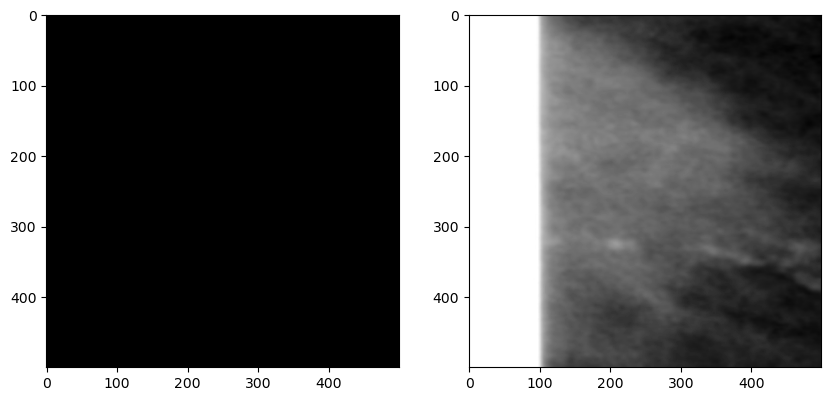

In [114]:
mask = cv2.imread('/mnt/d/Datasets/CBIS-DDSM/manifest-ZkhPvrLo5216730872708713142/CBIS-DDSM/Mass-Training_P_00076_LEFT_CC_1/07-21-2016-DDSM-NA-20119/1.000000-ROI mask images-13422/1-2.png',cv2.IMREAD_GRAYSCALE)
img = cv2.imread('/mnt/d/CBIS-DDSM/new_ROI/ROI_ORIGINAL/train/malignant/Mass-Training_P_00720_RIGHT_MLO_1_1.png',cv2.IMREAD_GRAYSCALE)
# img, modified_mask, breast_mask, mask = remove_artifacts(img,None,False)
import cv2
import numpy as np
border_y = 5
border_x = 5
# Crop out some of the borders
rect = cv2.rectangle(img=np.zeros((img.shape),dtype='uint8'),pt1=(border_x,border_y),pt2=(img.shape[1]-border_x, img.shape[0]-border_y),color=(255,255,255),thickness=-1)
# rectmask = cv2.bitwise_and(img,img,mask=rect)

# Apply Canny edge detection
edges = cv2.Canny(img, 100, 150, apertureSize=3)
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create mask
mask = np.ones_like(img, dtype=np.uint8)

# Loop over contours
for contour in contours:
    # Compute bounding rectangle
    x, y, w, h = cv2.boundingRect(contour)
    
    # Check if rectangle intersects with image border
    if x <= 0 or y <= 0 or x + w >= img.shape[1] or y + h >= img.shape[0]:
        # Set corresponding region in mask to 0
        mask[y:y+h, x:x+w] = 0

# Apply mask to image
masked_img = cv2.bitwise_and(img, img, mask=mask)
# _,thresh = cv2.threshold(masked_img,127,255,cv2.THRESH_OTSU)
# contours,_= cv2.findContours(thresh,mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
# contour_placeholder = np.zeros((masked_img.shape),np.uint8())
# largest_contour = max(contours,key=cv2.contourArea)
# contour_mask = cv2.drawContours(contour_placeholder,[largest_contour],contourIdx=0,color=(255,255,255),thickness=-1)
# kernel = np.ones((10,10),np.uint8)
# contour_mask = cv2.erode(cv2.dilate(contour_mask, kernel, iterations=5),kernel,iterations=1)
# masked_img = cv2.bitwise_and(masked_img,masked_img,mask=contour_mask)


plt.figure(figsize=(10,20))
plt.subplot(121)
plt.imshow(edges,cmap='gray')
plt.subplot(122)
plt.imshow(masked_img,cmap='gray')

Calc-Test_P_01414_RIGHT_CC

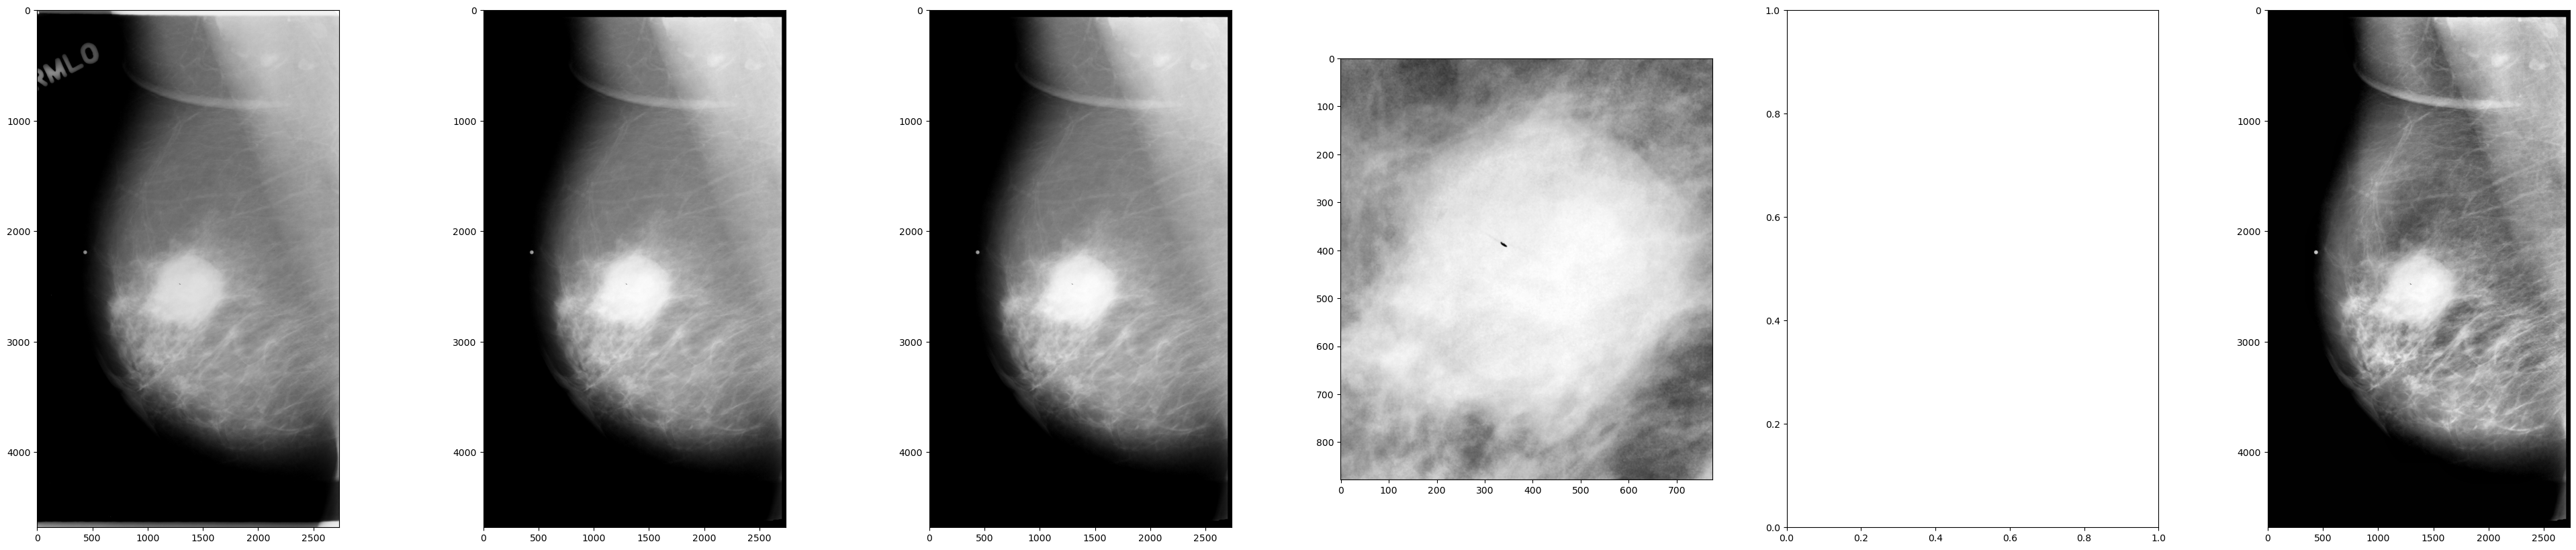

In [11]:
mask = cv2.imread('/mnt/d/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.285138900913160236325681278743831954285/1-081.jpg',cv2.IMREAD_GRAYSCALE)
data = cv2.imread('/mnt/c/Users/user/Desktop/CBIS-DDSM/full/train/malignant/Mass-Training_P_00314_RIGHT_MLO.png',cv2.IMREAD_GRAYSCALE)
# img, modified_mask, breast_mask, mask = remove_artifacts(data,mask,False)
data_og=data.copy()
border_y = int(0.01*data.shape[0])
border_x = int(0.01*data.shape[1])
# Crop out some of the borders
rect = cv2.rectangle(img=np.zeros((data.shape),dtype='uint8'),pt1=(border_x,border_y),pt2=(data.shape[1]-border_x, data.shape[0]-border_y),color=(255,255,255),thickness=-1)
data_rect = cv2.bitwise_and(data,data,mask=rect)
contours,_= cv2.findContours(data_rect,mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
contour_placeholder = np.zeros((data.shape),np.uint8())
largest_contour = max(contours,key=cv2.contourArea)
contour_mask_rect = cv2.drawContours(contour_placeholder,[largest_contour],contourIdx=0,color=(255,255,255),thickness=-1)
kernel = np.ones((10,10),np.uint8)
contour_mask = contour_mask_rect
contour_mask = cv2.erode(cv2.dilate(contour_mask, kernel, iterations=5),kernel,iterations=1)
data_cont_rect = cv2.bitwise_and(data_rect,data_rect,mask=contour_mask_rect)
canny = cv2.Canny(data_cont_rect,50,150,apertureSize=3)
canny = cv2.dilate(canny, np.ones((5,5),np.uint8), iterations=1)
# _,thresh = cv2.threshold(canny,0,255,cv2.THRESH_BINARY)
contour, _ = cv2.findContours(canny,mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
contours = []
for cont in contour:
    if cv2.contourArea(cont) > 5000:
        contours.append(cont)
if contours:
    canny_mask = cv2.drawContours(np.ones((data.shape),np.uint8()),contours,contourIdx=-1,color=(0,0,0),thickness=-1)
    canny_mask = np.invert(canny_mask)
    kernel = np.ones((10,10),np.uint8)
    canny_mask = cv2.dilate(canny_mask, kernel, iterations=3)
    canny_mask = np.invert(canny_mask)
    data_canny = cv2.bitwise_and(data_cont_rect,data_cont_rect,mask=canny_mask)

# data = data.astype('float')/255.0
# data_gamma = 255 * np.power((data_canny/255.0),2)
# data_gamma = data_gamma.astype('uint8')
data_median = cv2.medianBlur(data_canny,3)
# data_gcn = GCN(data_median)
clahe = cv2.createCLAHE(2.0,(8,8))
data_clahe = clahe.apply(data_median)
x,y,w,h = bounding_box(mask)
data_roi = data_clahe[y:y+h,x:x+w]

# data = data_gamma.astype('float')/255.0
# data_gcn = ((data - np.mean(data))).astype(np.uint8)
# data_gcn = ((data - np.min(data)) * 255 / (np.max(data) - np.min(data))).astype(np.uint8)

plt.figure(figsize=(50,10))
plt.subplot(161)
plt.imshow(data_og,cmap='gray')
plt.subplot(162)
plt.imshow(data_canny,cmap='gray')
plt.subplot(163)
plt.imshow(data_median,cmap='gray')
plt.subplot(164)
plt.imshow(data_roi,cmap='gray')
plt.subplot(165)
# plt.imshow(data_gcn,cmap='gray')
plt.subplot(166)
plt.imshow(data_clahe,cmap='gray')

(145, 102)
(145, 102)
(145, 102)
(145, 102)
(145, 102)
(array([  0,   0,   0, ..., 144, 144, 144]), array([ 79,  80,  81, ...,  99, 100, 101]))
[0 0 0 ... 0 0 0]


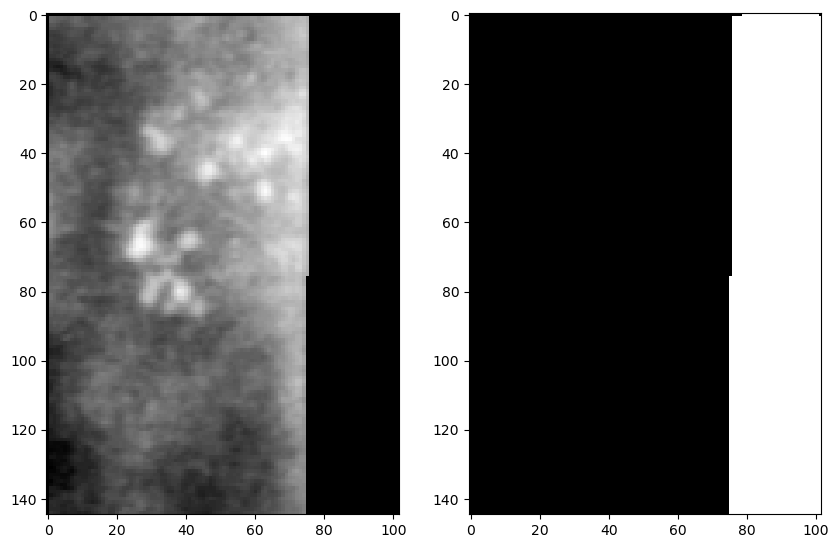

In [27]:
# mask = cv2.imread('/mnt/d/Datasets/CBIS-DDSM/manifest-ZkhPvrLo5216730872708713142/CBIS-DDSM/Calc-Test_P_01414_RIGHT_CC_1/08-29-2017-DDSM-NA-40350/1.000000-ROI mask images-67640/1-2.png',cv2.IMREAD_GRAYSCALE)
dataog = cv2.imread('/mnt/d/Datasets/CBIS-DDSM/ROI_without_artifact/train/benign/Calc-Training_P_00250_LEFT_MLO_1_1.png',cv2.IMREAD_GRAYSCALE)
# img, modified_mask, breast_mask, mask = remove_artifacts(data,mask,False)
data = dataog.copy()
border_y = 2
border_x = 2
# Crop out some of the borders
rect = cv2.rectangle(img=np.zeros((data.shape),dtype='uint8'),pt1=(border_x,border_y),pt2=(data.shape[1]-border_x, data.shape[0]-border_y),color=(255,255,255),thickness=-1)
data = cv2.bitwise_and(data,data,mask=rect)
# Mask the breast area and crop out the artifacts
canny = cv2.Canny(data,100,255,apertureSize=3)
canny = cv2.dilate(canny, np.ones((1,1),np.uint8), iterations=1)
# canny = cv2.dilate(canny, np.ones((5,5),np.uint8), iterations=1)
# _,thresh = cv2.threshold(canny,0,255,cv2.THRESH_BINARY)
contour, _ = cv2.findContours(canny,mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
contours = []

for cont in contour:
    if cv2.contourArea(cont)/(canny.shape[0]*canny.shape[1]) > 0.01:
        contours.append(cont)
# print(contours)
if contours:
    print(data.shape)
    canny_mask = cv2.drawContours(np.ones((data.shape),np.uint8()),contours,contourIdx=-1,color=(255,255,255),thickness=-1)
    # canny_mask = np.invert(canny_mask)
    
    
    
    
    
    # dist_transform *= 255
    kernel = np.ones((7,7),np.uint8)
    canny_mask = cv2.dilate(~canny_mask, np.ones((5,5),np.uint8), iterations=1)
    canny_mask = cv2.erode(canny_mask,kernel,iterations=1)
    canny_mask = np.invert(canny_mask)
    dist_transform_1 = cv2.distanceTransform(~canny_mask, cv2.DIST_L2, 3,dstType=cv2.CV_8U)
    
    dist_transform = cv2.normalize(dist_transform_1, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    # print(dist_transform)
    # dist_transform = cv2.cvtColor(dist_transform, cv2.COLOR_GRAY2BGR)
    dist_transform = dist_transform.astype('uint8')
    print(data.shape)
    print(canny_mask.shape)
    print(dist_transform.shape)
    print(dataog.shape)
    # data[canny_mask > 0] = dataog[dist_transform > 0]
    # print([np.where(canny_mask == 255)])
    data = cv2.bitwise_and(dataog,dataog,mask=~canny_mask)
    print(np.where(canny_mask == 255))
    coord = []
    for x in np.where(canny_mask == 255):
        coord.append(x)
    # for i in len(coord[0]):
    for i in range(len(coord[0])):
        x = coord[1][i]
        y = coord[0][i]
    data[np.where(canny_mask == 255)] = data[np.where(dist_transform == np.min(dist_transform[np.where(canny_mask == 255)]))]
    print(data[np.where(dist_transform == np.min(dist_transform[np.where(canny_mask == 255)]))])
    
    # img_copy=data.copy()
    # img_copy[mask > 0] = data[dist_transform > 0]
    # cv2.dilate(~canny_mask, kernel, iterations=1)
# data = data.astype('float')/255.0
# data = np.power(data,2)
# data = data * 255.0
dataog = dataog.astype('uint8')
# clahe = cv2.createCLAHE(1.0,(8,8))
# data = clahe.apply(data)



plt.figure(figsize=(10,20))
plt.subplot(121)
plt.imshow(data,cmap='gray')
plt.subplot(122)
plt.imshow(canny_mask,cmap='gray')

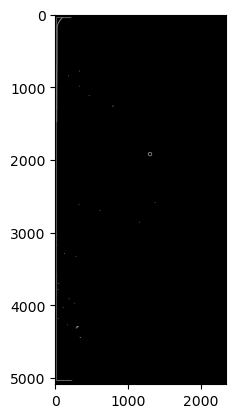

In [102]:
data = cv2.imread('/mnt/c/Users/user/Desktop/CBIS-DDSM/full/test/benign/Calc-Test_P_01414_RIGHT_CC.png',cv2.IMREAD_GRAYSCALE)
border_y = int(0.01*data.shape[0])
border_x = int(0.01*data.shape[1])
# border_x=5
# Crop out some of the borders
rect = cv2.rectangle(img=np.zeros((data.shape),dtype='uint8'),pt1=(border_x,border_y),pt2=(data.shape[1]-border_x, data.shape[0]-border_y),color=(255,255,255),thickness=-1)
data = cv2.bitwise_and(data,data,mask=rect)
# Mask the breast area and crop out the artifacts
_,thresh = cv2.threshold(data,127,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)
contours,_= cv2.findContours(data,mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
contour_placeholder = np.zeros((data.shape),np.uint8())
largest_contour = max(contours,key=cv2.contourArea)
contour_mask = cv2.drawContours(contour_placeholder,[largest_contour],contourIdx=0,color=(255,255,255),thickness=-1)
data = cv2.bitwise_and(data,data,mask=contour_mask)
canny = cv2.Canny(data,50,150,apertureSize=3)
canny = cv2.dilate(canny, np.ones((5,5),np.uint8), iterations=1)
houghline = cv2.HoughLines(canny,rho=1,theta=np.pi/50,threshold=50)
for line in houghline:
    rho, theta = line[0]
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    cv2.line(data, (x1, y1), (x2, y2), (0, 0, 255), 2)
plt.imshow(canny,cmap='gray')

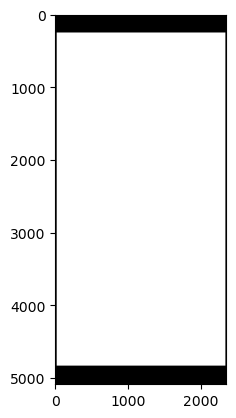

In [54]:
border_y = int(0.05*data.shape[0])
border_x = int(0.01*data.shape[1])
rect = cv2.rectangle(img=np.zeros((data.shape),dtype='uint8'),pt1=(border_x,border_y),pt2=(data.shape[1]-border_x, data.shape[0]-border_y),color=(255,255,255),thickness=-1)
plt.imshow(rect,cmap='gray')

In [11]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomZoom(height_factor=(0,-0.5),width_factor=(0,-0.5),fill_mode='constant')
  ])

## GCN Test

9
181
0.6353864923747277
1.5177394335511982


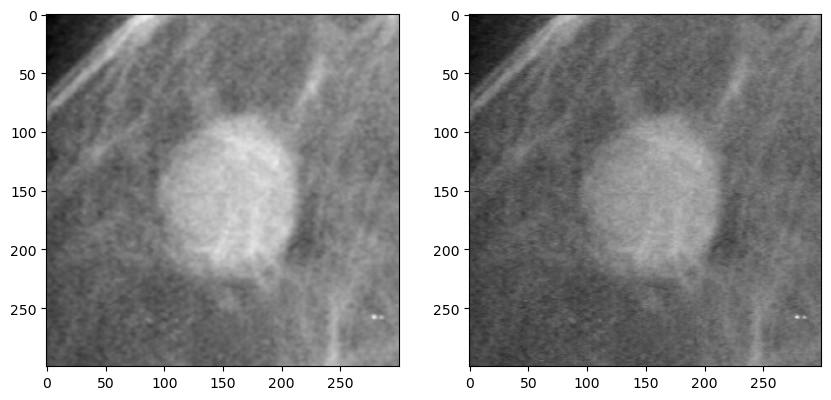

In [25]:

data = cv2.imread('/mnt/d/CBIS-DDSM/new_ROI/augmented/test/benign/Mass-Test_P_00099_LEFT_MLO_1_1.png',cv2.IMREAD_GRAYSCALE)
# testclahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(1,1))
# data = cv2.normalize(data, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
# data = GCN(data)
# print(data.max())
gaus_data = cv2.GaussianBlur(data,(3,3),cv2.BORDER_DEFAULT)
# norm_data = normalize_breast(gaus_data)
# norm_data2 = cv2.normalize(gaus_data, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
print(np.min(gaus_data))
print(np.max(gaus_data))
data = data/255.0
data_mean = np.mean(data)
norm_data2 = ((data-np.mean(data)+1))
norm_data2 = np.where(norm_data2 == 1-data_mean,0,norm_data2)
M = cv2.getRotationMatrix2D((300/2, 300/2), 30, 1)
# Perform rotation and store result in rotated variable
img4 = cv2.warpAffine(norm_data2, M, (300, 300))
print(norm_data2.min())
print(norm_data2.max())
# med_data = cv2.medianBlur(norm_data,3)
# med_data2 = cv2.medianBlur(norm_data2,3)
plt.figure(figsize=(10,20))
plt.subplot(121)
plt.imshow(gaus_data,cmap='gray')
plt.subplot(122)
plt.imshow(data,cmap='gray')


[[ 57   0   0 ...   0   0   0]
 [ 56   0   0 ...   0   0   0]
 [ 56   0   0 ...   0   0   0]
 ...
 [ 37   0   0 ... 109 110 110]
 [ 38   0   0 ... 108 108 108]
 [ 43   0   0 ... 108 108 108]]


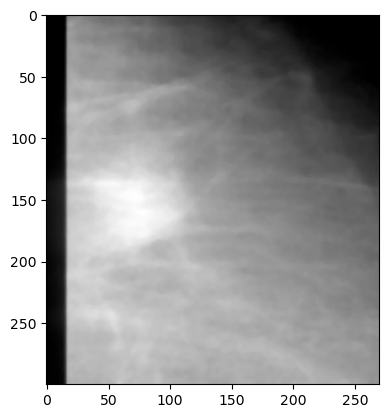

In [24]:
data = cv2.imread('/mnt/d/CBIS-DDSM/new_ROI/augmented/train/malignant/Mass-Training_P_01445_RIGHT_CC_1_1.png',cv2.IMREAD_GRAYSCALE)
print(data)
ret,thresh = cv2.threshold(data,10,255,cv2.THRESH_BINARY)
contours, _ = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
if contours:
    largest_contours = max(contours, key=cv2.contourArea)
    x,y,w,h = cv2.boundingRect(largest_contours)
    img_contour = np.zeros(data.shape,np.uint8)
    plt.imshow(cv2.drawContours(img_contour, [largest_contours], -1, 255, -1))
    if w>50 and h>50:
        data = data[y:y+h,x:x+w]
ret,thresh = cv2.threshold(data,200,255,cv2.THRESH_BINARY)
contours, _ = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
if contours:
    largest_contours = max(contours, key=cv2.contourArea)
    x,y,w,h = cv2.boundingRect(largest_contours)
    img_contour = np.zeros(data.shape,np.uint8)
    plt.imshow(cv2.drawContours(img_contour, [largest_contours], -1, 255, -1))
    if w< data.shape[1]/2:
        if x+w == data.shape[1]:
            data = data[:,:data.shape[1]-w]
        elif x == 0:
            data = data[:,w:]
    if h< data.shape[0]/2:
        if y+h == data.shape[0]:
            data = data[:data.shape[1]-h,:]
        elif y == 0:
            data = data[h:,:]
# data = cv2.normalize(data, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
plt.imshow(data,cmap='gray')

In [28]:
def global_contrast_normalization(image, scale=1.0, subtract_mean=True, use_std=True, sqrt_bias=1e-6):
    """
    Apply global contrast normalization to an image.
    Args:
        image (numpy.ndarray): input image.
        scale (float): scaling factor for normalized values.
        subtract_mean (bool): whether to subtract mean of image values.
        use_std (bool): whether to divide by standard deviation of image values.
        sqrt_bias (float): factor to prevent division by zero.
    Returns:
        numpy.ndarray: normalized image.
    """
    if subtract_mean:
        image = image - np.mean(image)

    if use_std:
        image = image / np.sqrt(np.var(image) + sqrt_bias)

    return scale * image

296
8


True

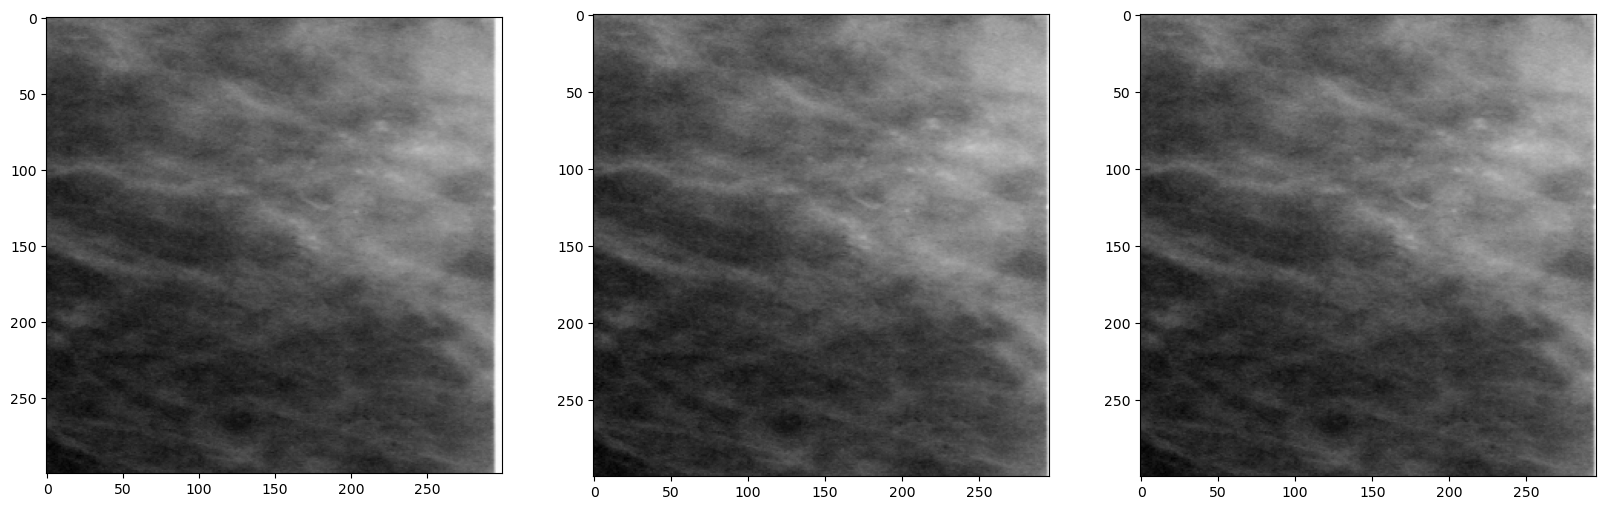

In [52]:
plt.figure(figsize=(20,60))
data = cv2.imread('/mnt/d/Datasets/CBIS-DDSM/ROI/augmented/train/malignant/P_01198_RIGHT_CC_1_1.png', cv2.IMREAD_GRAYSCALE)
plt.subplot(131)
plt.imshow(data,cmap='gray')
# data = global_contrast_normalization(data,scale=1,sqrt_bias=10,use_std=True)
# print(data)
ret,thresh = cv2.threshold(data,250,255,0)
contours, _ = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
# print(contours)
if contours:
  # cnt = contours[-1]
  largest_contours = max(contours, key=cv2.contourArea)
  x,y,w,h = cv2.boundingRect(largest_contours)
  print(x)
  # img = cv2.drawContours(data,[cnt],0,(255,255,255),2)
#   if w>10 and h>10:
  if x+w == data.shape[1]:
    data = data[:,:data.shape[1]-w]
  # elif x-w == 0:
    # data = data[y:y+h,w:]
# data = cv2.normalize(data, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
# print(data.min())
plt.subplot(132)
plt.imshow(data,cmap='gray')
# data = np.interp(data,(data.min(),data.max()),(0,255)).astype(dtype=np.uint8)
print(data.min())
# testclahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(1,1))
data = cv2.normalize(data, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
# data = testclahe.apply(data)
plt.subplot(133)
plt.imshow(data,cmap='gray')
cv2.imwrite('/mnt/d/Datasets/CBIS-DDSM/testing1.png',data)

In [59]:
np.where(img_id == "523cdecbef6f4fa9ec4c49ead52846ba" )

(array([2094, 2095]),)

(3580, 2812)


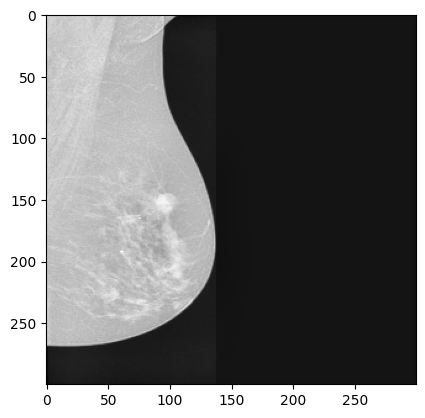

In [58]:
data = pydicom.dcmread(imgPATH+"afa015c6fcf47f108939c6663af44990/523cdecbef6f4fa9ec4c49ead52846ba.dicom")
# data = pydicom.dcmread(imgPATH+filename[0]+'/'+img_id[0]+".data")
data = data.pixel_array.astype(float)
data = (np.maximum(data,0)/data.max())*255.0

data = np.uint8(data)
# # # data = cv2.medianBlur(data,3)
# data = np.invert(data)
print(data.shape)

# data = data[int(mask_y_min[20140]):int(mask_y_max[20140]),int(mask_x_min[20140]):int(mask_x_max[20140])]
data = clahe.apply(data)
data = cv2.resize(data,(300,300))
plt.imshow(data, cmap="gray")

# cv2.imwrite(PATH+"test.png",data)

In [21]:
from preprocess import DMImagePreprocessor
preprocess = DMImagePreprocessor()

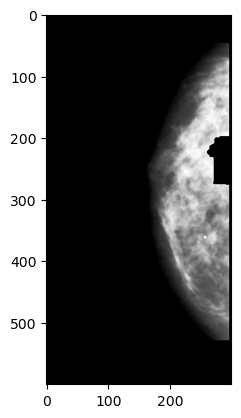

In [32]:
img = cv2.imread('/mnt/d/Datasets/CBIS-DDSM/full_mammogram_image/augmented/train/malignant/Calc-Training_P_00855_RIGHT_CC.png',cv2.IMREAD_GRAYSCALE)                      
image,mask = preprocess.process(img=img, median_filtering=True, blur_kn_size=3, 
                                artif_suppression=True, low_int_threshold=.05, kernel_size=15,
                                pect_removal=False, high_int_threshold=.8)

plt.imshow(mask,cmap='gray')

In [2]:
import simple_load_data as loaddata
import random
from collections import defaultdict, Counter

In [3]:
train,test = loaddata.load_all_files()

In [6]:
groups = np.array(train[2]['new_labels'].values)
groups

array([3, 3, 1, ..., 2, 2, 2], dtype=uint8)

In [7]:
folds = loaddata.divide_into_k_folds(train[2],k=5)


In [8]:
train_set = []
for fold in folds[:-1]:
    for indice in fold:
        train_set.append(indice)
val_set = folds[-1]



In [9]:
for i in train_set:
    if i in val_set:
        print(i)

In [10]:
print(len(test[1]))

653


In [20]:
test_img = []
test_label = []
for i in range(len(test[1])):
    if test[1][i] == 0 or test[1][i] ==2:
        test_img.append(test[0][i])
        test_label.append(test[1][i])

In [21]:
0 in test[1]

True

In [94]:
train_img = []
train_label = []
for i in train_set:
    if train[1][i] == 0 or train[1][i] ==2:
        train_img.append(train[0][i])
        train_label.append(train[1][i])
val_img = []
val_label = []
for i in val_set:
    if train[1][i] == 0 or train[1][i] ==2:
        val_img.append(train[0][i])
        val_label.append(train[1][i])
print(len(train_img))

955


In [105]:
save_path = '/mnt/d/CBIS_DDSM_Patch/png/train/'
i=0
for labels in train_label:
    img = train_img[i]
    img = cv2.resize(img,(300,300))
    if labels == 0:
        malignancy = 'benign/'
    elif labels == 2:
        malignancy = 'malignant/'
    cv2.imwrite(save_path + malignancy + str(i+1)+'.png', img)
    i+=1


In [106]:
save_path = '/mnt/d/CBIS_DDSM_Patch/png/val/'
i=0
for labels in val_label:
    img = val_img[i]
    img = cv2.resize(img,(300,300))
    if labels == 0:
        malignancy = 'benign/'
    elif labels == 2:
        malignancy = 'malignant/'
    cv2.imwrite(save_path + malignancy + str(i+1)+'.png', img)
    i+=1












In [ ]:
save_path = '/mnt/d/CBIS_DDSM_Patch/png/test/'
i=0
for labels in test_label:
    img = test_img[i]
    img = cv2.resize(img,(300,300))
    if labels == 0:
        malignancy = 'benign/'
    elif labels == 2:
        malignancy = 'malignant/'
    cv2.imwrite(save_path + malignancy + str(i+1)+'.png', img)
    i+=1


In [ ]:
if not os.path.exists(directory):
    os.makedirs(directory)

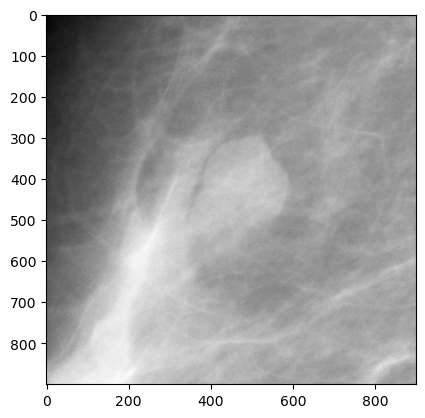

In [92]:
plt.imshow(train_img[5],cmap='gray')

In [69]:
print(len(train_set))

1788


In [72]:
folds

[array([  17,   18,   26,   27,   28,   29,   30,   31,   47,   48,   55,
          56,   59,   60,   63,   64,   65,   72,   81,   87,   88,   89,
          90,   96,   97,  113,  114,  126,  127,  132,  133,  134,  135,
         138,  139,  140,  141,  142,  143,  144,  155,  156,  161,  162,
         163,  164,  165,  171,  172,  208,  213,  214,  217,  218,  219,
         221,  222,  225,  226,  232,  233,  243,  244,  258,  259,  292,
         293,  308,  309,  331,  332,  337,  362,  363,  366,  367,  380,
         381,  387,  388,  389,  390,  395,  403,  404,  417,  418,  419,
         420,  422,  423,  433,  434,  437,  438,  449,  450,  459,  460,
         461,  462,  472,  487,  488,  499,  500,  505,  506,  508,  509,
         510,  511,  515,  516,  517,  520,  521,  530,  533,  534,  535,
         537,  538,  558,  559,  570,  571,  579,  581,  582,  585,  586,
         595,  598,  599,  602,  603,  624,  625,  628,  629,  630,  631,
         646,  647,  648,  655,  656, 

In [50]:
for x in train[1]:
    print(x)

3
3
1
1
1
1
3
3
1
3
3
1
1
3
3
1
1
1
1
1
3
3
3
3
3
3
3
3
3
3
3
3
3
3
1
1
1
1
3
3
1
1
3
3
1
3
3
3
3
3
3
1
1
3
3
1
1
3
3
1
1
1
1
3
3
3
1
3
3
3
3
3
1
3
3
1
1
1
1
1
1
1
1
1
3
3
3
1
1
1
1
3
1
1
1
1
1
1
1
1
3
3
3
3
1
1
3
3
1
1
1
1
3
3
3
3
3
1
1
1
1
3
3
1
3
3
1
1
3
3
1
1
1
1
1
1
3
3
1
1
1
1
1
1
1
3
3
1
1
1
1
1
1
1
1
3
3
1
1
1
1
3
3
1
3
3
1
1
1
1
1
1
1
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
3
1
1
1
1
1
1
1
1
1
1
1
3
3
3
3
3
3
3
1
1
3
3
3
3
1
1
1
1
1
1
1
3
3
1
1
3
3
3
3
3
3
3
3
1
1
1
3
3
1
1
1
1
1
1
1
1
3
3
3
3
3
1
1
3
3
3
3
3
3
3
3
3
1
1
1
1
1
1
3
3
3
1
1
1
1
1
1
1
3
3
3
3
3
1
1
3
3
3
3
1
1
3
1
1
3
1
1
1
1
3
3
3
3
1
1
1
3
1
3
3
3
3
3
1
1
1
1
1
1
1
1
3
3
1
3
3
1
1
1
1
1
1
1
3
3
1
1
3
3
3
3
1
1
1
1
1
1
3
3
1
1
1
1
1
1
1
1
3
3
3
3
3
3
3
3
1
1
1
1
1
1
3
3
1
1
1
1
1
3
3
3
3
3
3
3
3
1
1
1
1
3
3
3
3
1
1
1
1
1
1
3
3
3
3
3
3
3
3
1
1
1
1
1
1
1
3
3
1
1
1
1
1
1
1
1
1
3
3
1
1
1
1
3
3
1
1
3
3
1
1
3
3
1
1
3
3
1
1
3
3
3
3
3
3
1
1
1
1
1
1
1
1
3
3
3
3
1
1
1
1
1
1
1
3
1
1
3
3
1
1
3
3
3
3
3
3
3
1
3
1
1
1
3


In [43]:
train_set = []
for i in folds[:4]:
    print(train[1].shape)
    


(2233,)
(2233,)
(2233,)
(2233,)


In [45]:
array = [0,1,2,3,4,0,12,3]
# array = np.where(array==0,)
print(np.mean(np.where(array==0,np.nan,array)))

3.125


[[167 167 167 ... 137 138 138]
 [167 166 166 ... 137 137 137]
 [166 166 166 ... 137 137 136]
 ...
 [ 66  65  65 ...  55  55  55]
 [ 68  66  66 ...  54  56  56]
 [ 68  67  65 ...  53  54  55]]


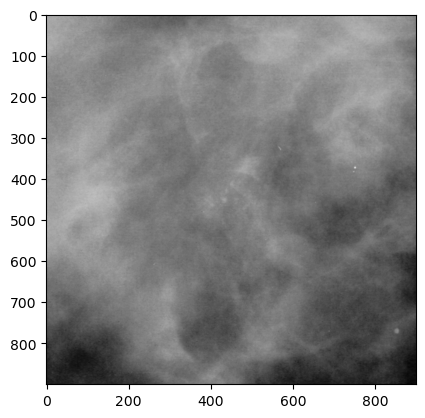

In [41]:
print(train_set[0][0][0])
plt.imshow(train_set[0][0][0],cmap='gray')